In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [88]:
file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_172322.ttbin' #QD_24 (PW)

In [89]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
fr = FileReader(file)
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-02-05 17:23:22 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [90]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

# measure photon antibunching
ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
ch2 = config['registered channels'][1] # second photon channel for antibunching measurements

cr = Countrate(virtual_tagger, [ch1, ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

print(f"Rate of counts channel {ch1} (counts_ON/sec) : {cr.getData()[0]}")
print(f"Rate of counts channel {ch2} (counts/sec) : {cr.getData()[1]}")

Rate of counts channel 1 (counts_ON/sec) : 8108.488017286788
Rate of counts channel 2 (counts/sec) : 7082.919910840626


In [91]:
fr = FileReader(file)
fr_copy = FileReader(file)

acc_list = []
n = 100
# treshold = 2*np.mean(cr.getData())*1e-12
treshold = 30000*1e-12
print("Treshold: ", treshold, "\n")
t_ant = 0

rates = np.array([])
times = np.array([])

IniInterval = abs(fr_copy.getData(1).getTimestamps())
EndInterval = 0

intervals_ON = np.array([])
ini_interval_ON = 0
end_interval_ON = 0
intervals_OFF = np.array([])
ini_interval_OFF = 0
end_interval_OFF = 0

not_saved = 0
saved = 0
flag_ON = 0
flag_OFF = 0

while (fr.hasData()):
    data = fr.getData(n)
    data_copy = fr_copy.getData(n)
    
    ts = data.getTimestamps()
    ts_copy = data_copy.getTimestamps()
    ch = data.getChannels()
    
    #EndInterval = (abs(ts[-1] + ts_copy[0]))/2
    EndInterval = (abs(ts[-1] + ts_copy[-1]))/2
    if EndInterval == IniInterval:
        break
    
    data_raw = np.array([ch, ts])
    
    # Restructure into columns (one for each channel)
    data_ch1 = data_raw[1, np.where(data_raw[0,:] == ch1)].copy() # Canal 1
    data_ch2 = data_raw[1, np.where(data_raw[0,:] == ch2)].copy() # Canal 2
    
    # Creating an empty array the size of the largest dataset
    data_ch = np.zeros([2, max(data_ch1.shape[1], data_ch2.shape[1])])
    
    # Filling the channel columns with the respective data (one of them will always fall short)
    data_ch[0, :data_ch1.shape[1]] += data_ch1[0]
    data_ch[1, :data_ch2.shape[1]] += data_ch2[0]
    
    # Check we get all data
    #print(data_ch1.size, data_ch2.size, data_ch1.size+data_ch2.size)
    
    delta_t = abs(IniInterval - EndInterval)
    rate = n / delta_t
    
    times = np.append(times, abs(IniInterval + EndInterval)/2)
    rates = np.append(rates,rate)
    
    if (rate > treshold):
        acc_list.append(data_ch - t_ant)
        saved += 1
        
        if(flag_ON == 0):
            #Beginning ON interval
            ini_interval_ON = IniInterval
            flag_ON = 1
        if(flag_OFF == 1):
            #End OFF interval
            end_interval_OFF = IniInterval
            intervals_OFF = np.append(intervals_OFF, abs(end_interval_OFF - ini_interval_OFF))
            flag_OFF = 0
            
    else:
        t_ant += delta_t
        not_saved += 1

        if(flag_ON == 1):
            #End ON interval
            end_interval_ON = IniInterval
            intervals_ON = np.append(intervals_ON, abs(end_interval_ON - ini_interval_ON))
            flag_ON = 0
            
        if(flag_OFF == 0):
            #Beginning OFF interval
            ini_interval_OFF = IniInterval
            flag_OFF = 1
            
    IniInterval = EndInterval

if(flag_ON == 1):
    #End of last ON interval
    end_interval_ON = IniInterval
    intervals_ON = np.append(intervals_ON, abs(end_interval_ON - ini_interval_ON))
if(flag_OFF == 1):
    #End of last OFF interval
    end_interval_OFF = IniInterval
    intervals_OFF = np.append(intervals_OFF, abs(end_interval_OFF - ini_interval_OFF))
    flag_OFF = 0

print("Saved: ", saved)
print("Not Saved: ", not_saved)

Treshold:  3e-08 

Saved:  13675
Not Saved:  37128


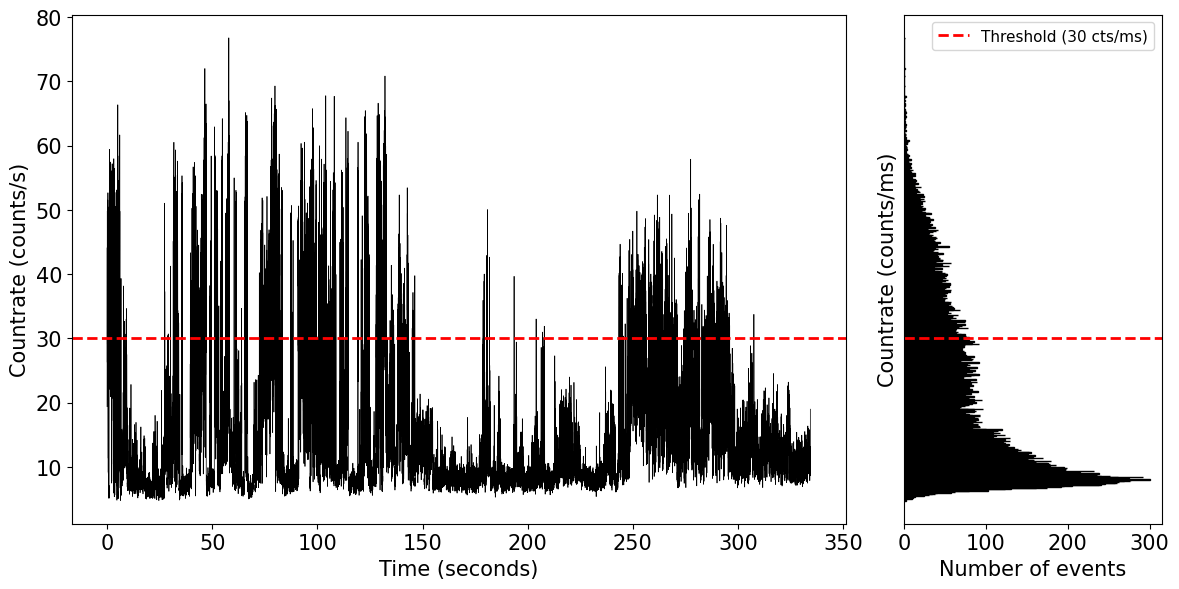

In [92]:
rates_hist = np.array(rates) * 1e9 #Pasamos la count-rate a counts/ms
times_hist = np.array(times - times[0]) * 1e-12 #Pasamos los tiempos a segundos

# Parámetros del histograma
num_bins = 1000
min_value = np.min(rates_hist)
max_value = np.max(rates_hist)

# Crear la figura y los subplots
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Definir tamaño de fuente
font_size = 15

# Gráfica de línea en el eje izquierdo
ax_scatter.plot(times_hist, rates_hist, color='black', linewidth=0.5)  # Línea fina negra conectando puntos
ax_scatter.axhline(y=treshold * 1e9, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e9:.0f})')
ax_scatter.set_xlabel('Time (seconds)', fontsize=font_size)
ax_scatter.set_ylabel('Countrate (counts/s)', fontsize=font_size)
ax_scatter.tick_params(axis='both', labelsize=font_size)

# Histograma en el eje derecho, rotado 90 grados
ax_hist.hist(rates_hist, bins=num_bins, range=(min_value, max_value), color='blue', edgecolor='black', orientation='horizontal')
ax_hist.axhline(y=treshold * 1e9, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e9:.0f} cts/ms)')
ax_hist.set_xlabel('Number of events', fontsize=font_size)
ax_hist.set_ylabel('Countrate (counts/ms)', fontsize=font_size)
ax_hist.set_yticks([])  # Eliminar valores y etiquetas en el eje Y
ax_hist.tick_params(axis='both', labelsize=font_size)
ax_hist.legend(fontsize = 11)

# Ajustar el layout para que no se solapen
plt.tight_layout()
plt.show()


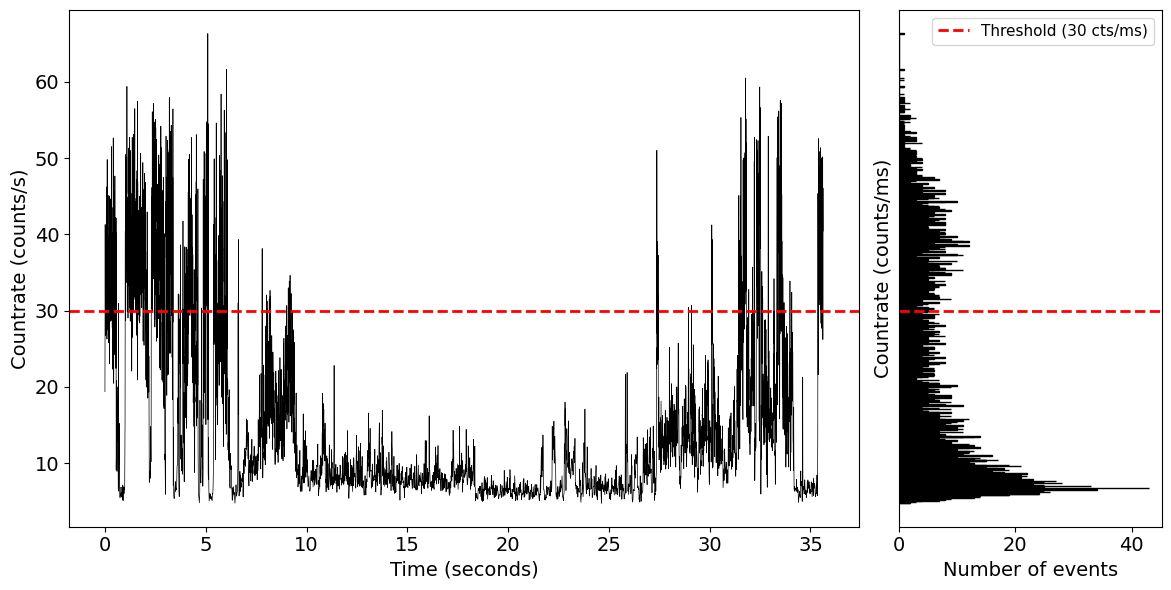

In [103]:
rates_hist = np.array(rates) * 1e9 #Pasamos la count-rate a counts/ms
times_hist = np.array(times - times[0]) * 1e-12 #Pasamos los tiempos a segundos

# Indices a representar
ini_index = 0
end_index = 4900

# Parámetros del histograma
num_bins = 1000
min_value = np.min(rates_hist[ini_index:end_index])
max_value = np.max(rates_hist[ini_index:end_index])

# Crear la figura y los subplots
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Gráfica de línea en el eje izquierdo
ax_scatter.plot(times_hist[ini_index:end_index], rates_hist[ini_index:end_index], color='black', linewidth=0.5)  # Línea fina negra conectando puntos
ax_scatter.axhline(y=treshold * 1e9, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e9:.0f})')
ax_scatter.set_xlabel('Time (seconds)', fontsize=font_size)
ax_scatter.set_ylabel('Countrate (counts/s)', fontsize=font_size)
ax_scatter.tick_params(axis='both', labelsize=font_size)

# Histograma en el eje derecho, rotado 90 grados
ax_hist.hist(rates_hist[ini_index:end_index], bins=num_bins, range=(min_value, max_value), color='blue', edgecolor='black', orientation='horizontal')
ax_hist.axhline(y=treshold * 1e9, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e9:.0f} cts/ms)')
ax_hist.set_xlabel('Number of events', fontsize=font_size)
ax_hist.set_ylabel('Countrate (counts/ms)', fontsize=font_size)
ax_hist.set_yticks([])  # Eliminar valores y etiquetas en el eje Y
ax_hist.tick_params(axis='both', labelsize=font_size)
ax_hist.legend(fontsize = 11)

# Ajustar el layout para que no se solapen
plt.tight_layout()
plt.show()

Exponential Decay Fit Parameters:
A = 2176.559 ± 133.495
tau_0 = 0.0026 ± 0.0001 seconds 

Power Law Fit Parameters:
a = 0.047 ± 0.007
alpha = 0.6445 ± 0.0255


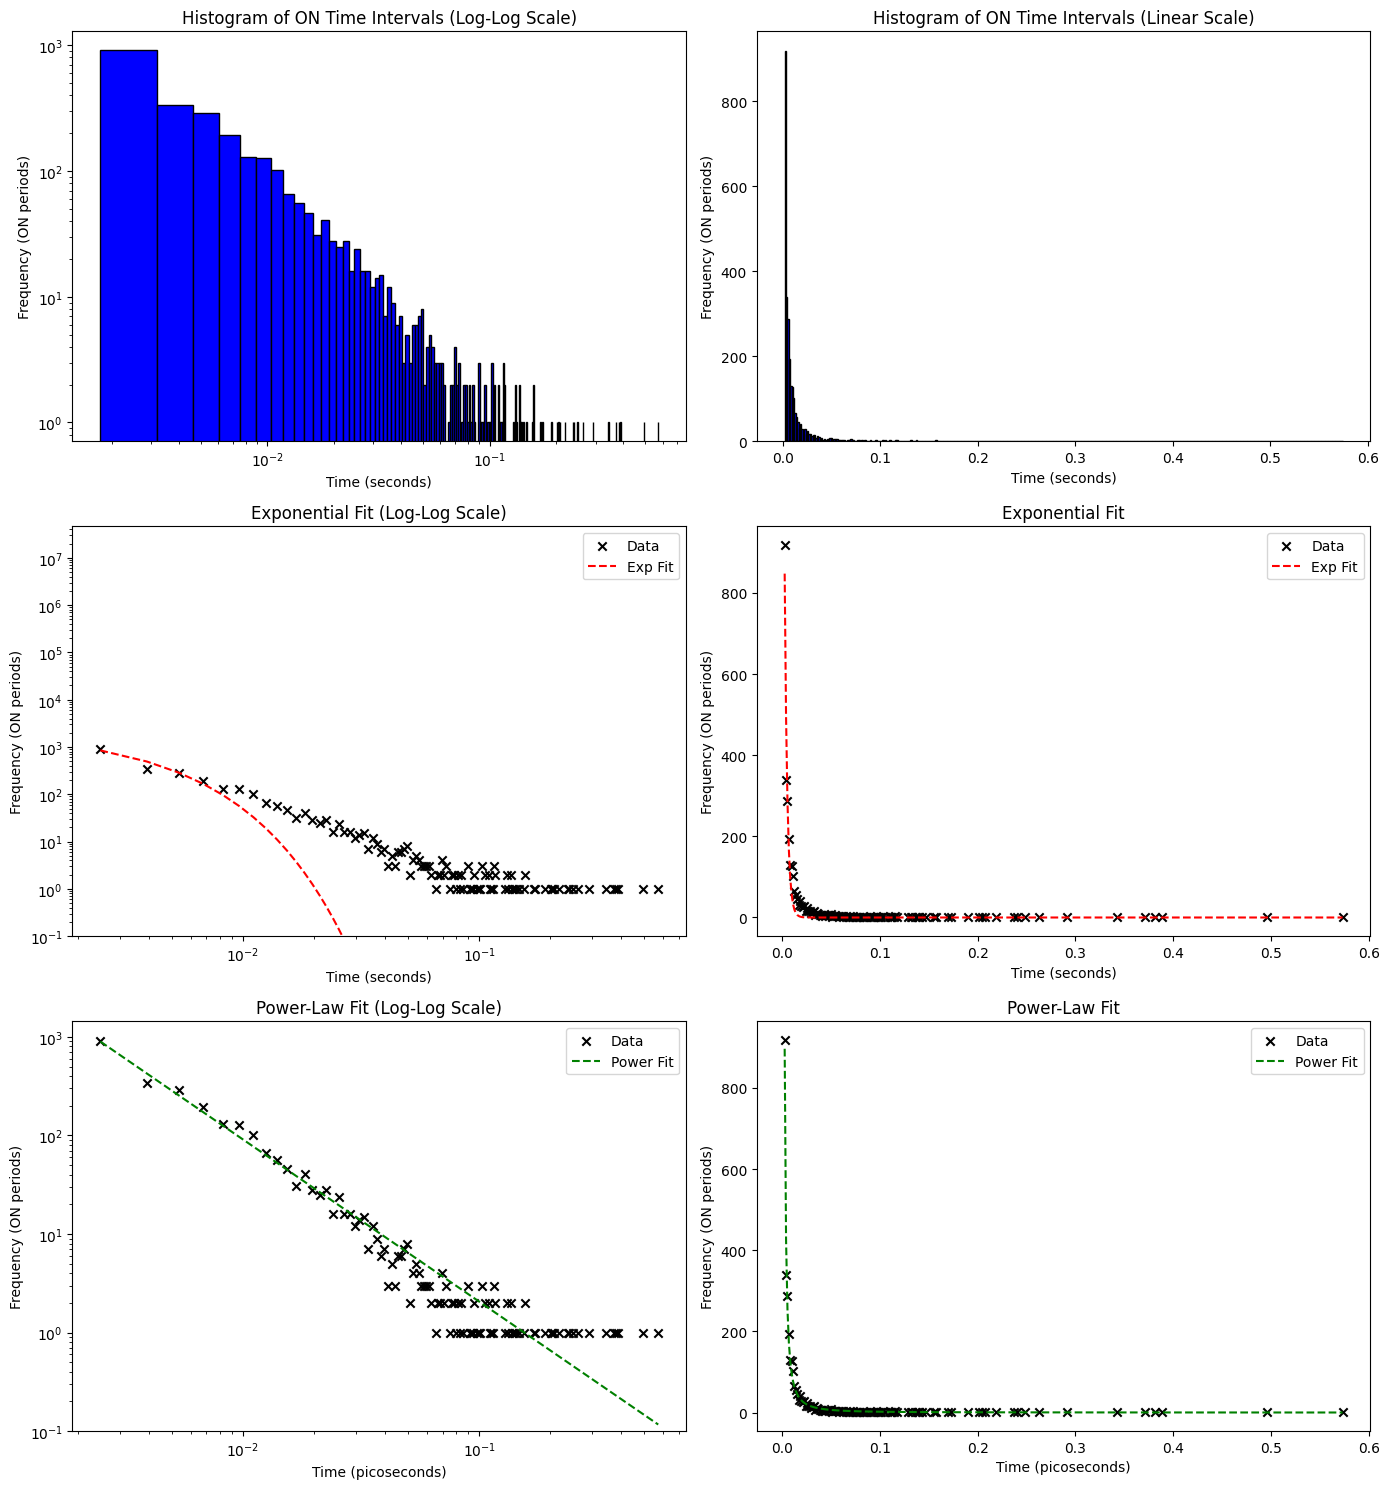

In [110]:
# Define parameters
n_bin_interval = 400
intervals_ON_sec = intervals_ON
intervals_ON_sec = intervals_ON * 1e-12 # Tenemos el tiempo en segundos
min_val = np.min(intervals_ON_sec)
max_val = np.max(intervals_ON_sec)

# Calculate histogram data for fitting
counts, bin_edges = np.histogram(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Creamos una máscara booleana donde counts no es igual a 0
mask = counts != 0
# Aplicamos la máscara a ambos arrays
counts_ON = counts[mask]
bin_centers_ON = bin_centers[mask]

# ---- Define fit functions ----
def exponential_decay(tau, A, tau_0):
    return A * np.exp(-tau / tau_0)

def power_law(tau, a, alpha):
    return a * tau ** (-1 - alpha)

# ---- Perform fits ----
# Initial parameter guesses
exp_initial_guess = [max(counts_ON), 1]
power_initial_guess = [max(counts_ON), 1]

# Fit exponential decay
exp_params, exp_covariance = curve_fit(exponential_decay, bin_centers_ON, counts_ON, p0=exp_initial_guess)
exp_errors = np.sqrt(np.diag(exp_covariance))  # Errors are the square root of the diagonal of the covariance matrix

# Fit power law
power_params, power_covariance = curve_fit(power_law, bin_centers_ON, counts_ON, p0=power_initial_guess)
power_errors = np.sqrt(np.diag(power_covariance))

# ---- Print parameters and errors ----
print("Exponential Decay Fit Parameters:")
print(f"A = {exp_params[0]:.3f} ± {exp_errors[0]:.3f}")
print(f"tau_0 = {exp_params[1]:.4f} ± {exp_errors[1]:.4f} seconds \n")
print("Power Law Fit Parameters:")
print(f"a = {power_params[0]:.3f} ± {power_errors[0]:.3f}")
print(f"alpha = {power_params[1]:.4f} ± {power_errors[1]:.4f}")

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 15))

# ---- Original Histogram ----
# Plot histogram with logarithmic scale
axs[0, 0].hist(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel("Time (seconds)")
axs[0, 0].set_ylabel("Frequency (ON periods)")
axs[0, 0].set_title("Histogram of ON Time Intervals (Log-Log Scale)")

# Plot histogram with linear scale
axs[0, 1].hist(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 1].set_xlabel("Time (seconds)")
axs[0, 1].set_ylabel("Frequency (ON periods)")
axs[0, 1].set_title("Histogram of ON Time Intervals (Linear Scale)")

# ---- Scatter Plot of Binned Frequencies with Fits ----
# Plot scatter with log-log scale
axs[1, 0].scatter(bin_centers_ON, counts_ON, color='k', marker='x', label="Data")
axs[1, 0].plot(bin_centers_ON, exponential_decay(bin_centers_ON, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(bottom=1e-1)
axs[1, 0].set_xlabel("Time (seconds)")
axs[1, 0].set_ylabel("Frequency (ON periods)")
axs[1, 0].set_title("Exponential Fit (Log-Log Scale)")
axs[1, 0].legend()

# Plot scatter with linear scale
axs[1, 1].scatter(bin_centers_ON, counts_ON, color='k', marker='x', label="Data")
axs[1, 1].plot(bin_centers_ON, exponential_decay(bin_centers_ON, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 1].set_xlabel("Time (seconds)")
axs[1, 1].set_ylabel("Frequency (ON periods)")
axs[1, 1].set_title("Exponential Fit")
axs[1, 1].legend()

# ---- Individual Fit Plots ----
# Power-Law fit in log scale
axs[2, 0].scatter(bin_centers_ON, counts_ON, color='k', marker='x', label="Data")
axs[2, 0].plot(bin_centers_ON, power_law(bin_centers_ON, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].set_ylim(bottom=1e-1)
axs[2, 0].set_xlabel("Time (picoseconds)")
axs[2, 0].set_ylabel("Frequency (ON periods)")
axs[2, 0].set_title("Power-Law Fit (Log-Log Scale)")
axs[2, 0].legend()

# Power-law fit in log-log scale
axs[2, 1].scatter(bin_centers_ON, counts_ON, color='k', marker='x', label="Data")
axs[2, 1].plot(bin_centers_ON, power_law(bin_centers_ON, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 1].set_xlabel("Time (picoseconds)")
axs[2, 1].set_ylabel("Frequency (ON periods)")
axs[2, 1].set_title("Power-Law Fit")
axs[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

alpha = 0.6445 ± 0.0255


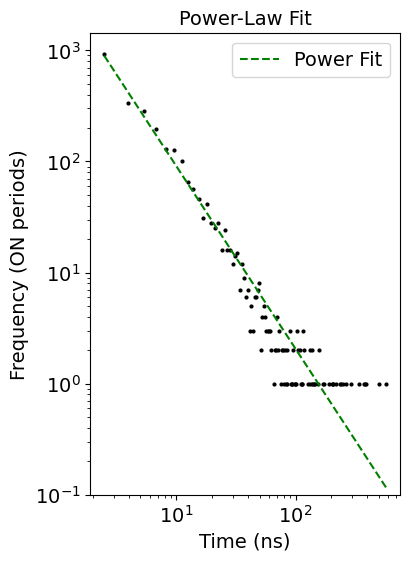

In [118]:
print(f"alpha = {power_params[1]:.4f} ± {power_errors[1]:.4f}")

# Definir el tamaño de la figura y la variable font_size
fig_size = (4, 6)  # tamaño de la figura (ancho, alto)
font_size = 14  # tamaño de la fuente

# Crear la figura con el tamaño deseado
plt.figure(figsize=fig_size)

# Power-law fit in log-log scale
plt.scatter(bin_centers_ON * 1000, counts_ON, color='k', marker='o', s=4)
plt.plot(bin_centers_ON * 1000, power_law(bin_centers_ON, *power_params), color='green', linestyle='--', label=f'Power Fit')

# Escala logarítmica en ambos ejes
plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel("Time (ns)", fontsize=font_size)
plt.ylabel("Frequency (ON periods)", fontsize=font_size)
plt.ylim(bottom=1e-1)
plt.title("Power-Law Fit", fontsize=font_size)

# Ajuste de tamaño de los valores de los ejes X e Y
plt.tick_params(axis='both', labelsize=font_size)

# Leyenda con tamaño de fuente variable
plt.legend(fontsize=font_size)

# Mostrar el gráfico
plt.show()

Exponential Decay Fit Parameters:
A = 5835.301 ± 202.052
tau_0 = 0.0061 ± 0.0002 seconds 

Power Law Fit Parameters:
a = 0.107 ± 0.006
alpha = 0.9843 ± 0.0115


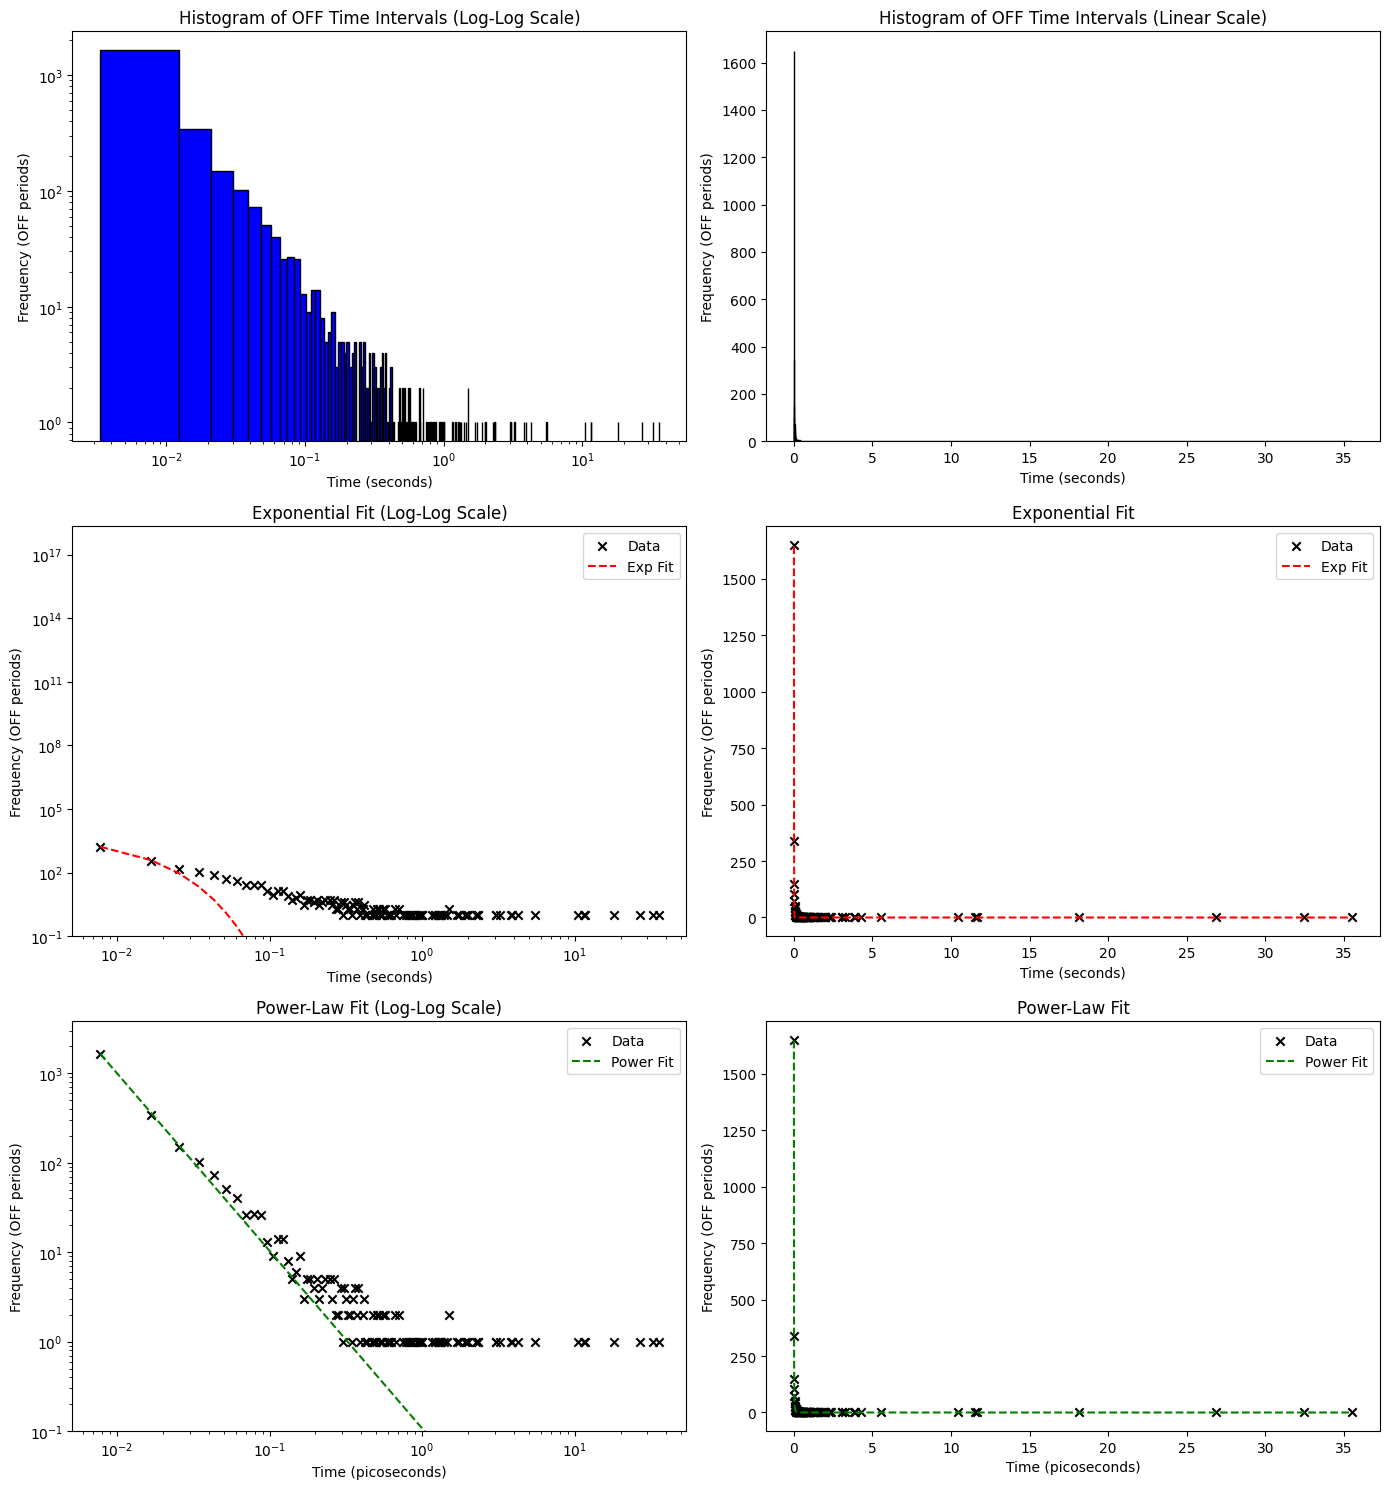

In [135]:
# Define parameters
n_bin_interval = 4000
intervals_OFF_sec = intervals_OFF
intervals_OFF_sec = intervals_OFF * 1e-12 # Tenemos el tiempo en segundos
min_val = np.min(intervals_OFF_sec)
max_val = np.max(intervals_OFF_sec)

# Calculate histogram data for fitting
counts, bin_edges = np.histogram(intervals_OFF_sec, bins=n_bin_interval, range=(min_val, max_val))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Creamos una máscara booleana donde counts no es igual a 0
mask = counts != 0
# Aplicamos la máscara a ambos arrays
counts_OFF = counts[mask]
bin_centers_OFF = bin_centers[mask]

# ---- Define fit functions ----
def exponential_decay(tau, A, tau_0):
    return A * np.exp(-tau / tau_0)

def power_law(tau, a, alpha):
    return a * tau ** (-1 - alpha)

# ---- Perform fits ----
# Initial parameter guesses
exp_initial_guess = [max(counts_OFF), 1]
power_initial_guess = [max(counts_OFF), 1]

# Fit exponential decay
exp_params, exp_covariance = curve_fit(exponential_decay, bin_centers_OFF, counts_OFF, p0=exp_initial_guess)
exp_errors = np.sqrt(np.diag(exp_covariance))  # Errors are the square root of the diagonal of the covariance matrix

# Fit power law
power_params, power_covariance = curve_fit(power_law, bin_centers_OFF, counts_OFF, p0=power_initial_guess)
power_errors = np.sqrt(np.diag(power_covariance))

# ---- Print parameters and errors ----
print("Exponential Decay Fit Parameters:")
print(f"A = {exp_params[0]:.3f} ± {exp_errors[0]:.3f}")
print(f"tau_0 = {exp_params[1]:.4f} ± {exp_errors[1]:.4f} seconds \n")
print("Power Law Fit Parameters:")
print(f"a = {power_params[0]:.3f} ± {power_errors[0]:.3f}")
print(f"alpha = {power_params[1]:.4f} ± {power_errors[1]:.4f}")

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 15))

# ---- Original Histogram ----
# Plot histogram with logarithmic scale
axs[0, 0].hist(intervals_OFF_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel("Time (seconds)")
axs[0, 0].set_ylabel("Frequency (OFF periods)")
axs[0, 0].set_title("Histogram of OFF Time Intervals (Log-Log Scale)")

# Plot histogram with linear scale
axs[0, 1].hist(intervals_OFF_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 1].set_xlabel("Time (seconds)")
axs[0, 1].set_ylabel("Frequency (OFF periods)")
axs[0, 1].set_title("Histogram of OFF Time Intervals (Linear Scale)")

# ---- Scatter Plot of Binned Frequencies with Fits ----
# Plot scatter with log-log scale
axs[1, 0].scatter(bin_centers_OFF, counts_OFF, color='k', marker='x', label="Data")
axs[1, 0].plot(bin_centers_OFF, exponential_decay(bin_centers_OFF, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(bottom=1e-1)
axs[1, 0].set_xlabel("Time (seconds)")
axs[1, 0].set_ylabel("Frequency (OFF periods)")
axs[1, 0].set_title("Exponential Fit (Log-Log Scale)")
axs[1, 0].legend()

# Plot scatter with linear scale
axs[1, 1].scatter(bin_centers_OFF, counts_OFF, color='k', marker='x', label="Data")
axs[1, 1].plot(bin_centers_OFF, exponential_decay(bin_centers_OFF, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 1].set_xlabel("Time (seconds)")
axs[1, 1].set_ylabel("Frequency (OFF periods)")
axs[1, 1].set_title("Exponential Fit")
axs[1, 1].legend()

# ---- Individual Fit Plots ----
# Power-Law fit in log scale
axs[2, 0].scatter(bin_centers_OFF, counts_OFF, color='k', marker='x', label="Data")
axs[2, 0].plot(bin_centers_OFF, power_law(bin_centers_OFF, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].set_ylim(bottom=1e-1)
axs[2, 0].set_xlabel("Time (picoseconds)")
axs[2, 0].set_ylabel("Frequency (OFF periods)")
axs[2, 0].set_title("Power-Law Fit (Log-Log Scale)")
axs[2, 0].legend()

# Power-law fit in log-log scale
axs[2, 1].scatter(bin_centers_OFF, counts_OFF, color='k', marker='x', label="Data")
axs[2, 1].plot(bin_centers_OFF, power_law(bin_centers_OFF, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 1].set_xlabel("Time (picoseconds)")
axs[2, 1].set_ylabel("Frequency (OFF periods)")
axs[2, 1].set_title("Power-Law Fit")
axs[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

alpha = 0.9843 ± 0.0115


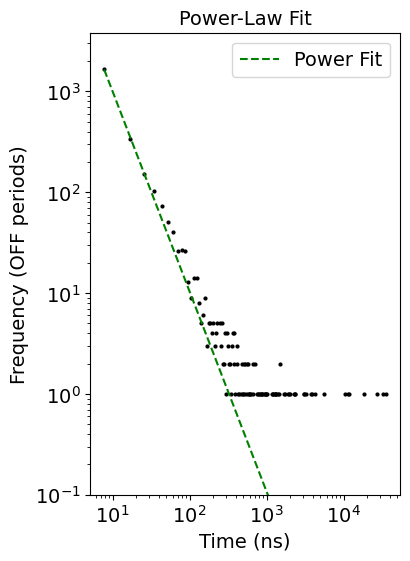

In [136]:
print(f"alpha = {power_params[1]:.4f} ± {power_errors[1]:.4f}")

# Definir el tamaño de la figura y la variable font_size
fig_size = (4, 6)  # tamaño de la figura (ancho, alto)
font_size = 14  # tamaño de la fuente

# Crear la figura con el tamaño deseado
plt.figure(figsize=fig_size)

# Power-law fit in log-log scale
plt.scatter(bin_centers_OFF * 1000, counts_OFF, color='k', marker='o', s=4)
plt.plot(bin_centers_OFF * 1000, power_law(bin_centers_OFF, *power_params), color='green', linestyle='--', label=f'Power Fit')

# Escala logarítmica en ambos ejes
plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel("Time (ns)", fontsize=font_size)
plt.ylabel("Frequency (OFF periods)", fontsize=font_size)
plt.ylim(bottom = 0.1)
plt.title("Power-Law Fit", fontsize=font_size)

# Ajuste de tamaño de los valores de los ejes X e Y
plt.tick_params(axis='both', labelsize=font_size)

# Leyenda con tamaño de fuente variable
plt.legend(fontsize=font_size)

# Mostrar el gráfico
plt.show()